In [1]:
%matplotlib inline


# ArrayTranslator for translating from proprietary file formats

**Suhas Somnath**

8/8/2017

This document illustrates an example of extracting data out of proprietary raw data files and writing the information
into a **Universal Spectroscopy and Imaging Data (USID)** HDF5 file (referred to as a **h5USID** file) using the
``pyUSID.ArrayTranslator``

<span style="color:red">**Note**: The Pycroscopy ecosystem of packages are moving away from ``Translators`` and towards [sidpy.Readers](https://pycroscopy.github.io/SciFiReaders/notebooks/00_basic_usage/plot_example_reader.html) instead.</span> 

We encourage users to use ``Translators`` over ``Readers`` only when it makes more sense to. 
<br>
<span style="color:red">**Note**: If your data has an N-dimensional form, consider [creating a sidpy.Dataset](https://pycroscopy.github.io/sidpy/notebooks/00_basic_usage/create_dataset.html) object and then writing the ``Dataset`` to a h5USID file using [pyUSID.hdf_utils.write_sidpy_dataset()](https://pycroscopy.github.io/pyUSID/_autosummary/pyUSID.io.hdf_utils.model.write_sidpy_dataset.html)  instead.</span> 
<br>

## Introduction
In most scientific disciplines, commercial instruments tend to write the data and metadata out into proprietary file
formats that significantly impede access to the data and metadata, thwart sharing of data and correlation of data from
multiple instruments, and complicate long-term archival, among other things. One of the data wrangling steps in science
is the extraction of the data and metadata out of the proprietary file formats and writing the information into files
that are easier to access, share, etc. The overwhelming part of this data wrangling effort is in investigating how to
extract the data and metadata into memory. Often, the data and parameters in these files are **not** straightforward to
access. In certain cases, additional / dedicated software packages are necessary to access the data while in many other
cases, it is possible to extract the necessary information from built-in **numpy** or similar python packages included
with **anaconda**. Once the information is accessible in the computer memory, such as in the
form of numpy arrays, scientists have a wide variety of tools to write the data out into files.

Simpler data such as images or single spectra can easily be written into plain text files. Simple or complex / large /
multidimensional data can certainly be stored as numpy data files. However, there are significant drawbacks to writing
data into non-standardized structures or file formats. First, while the structure of the data and metadata may be
intuitive for the original author of the data, that may not be the case for another researcher. Furthermore, such
formatting may change from a day-to-day basis. As a consequence, it becomes challenging to develop code that can accept
such data whose format keeps changing.

One solution to these challenges is to write the data out into standardized files such as ``h5USID`` files.
The USID model aims to make data access, storage, curation, etc. simply by storing the data along with all
relevant parameters in a single file (HDF5 for now).

The process of copying data from the original format to **h5USID** files is called
**Translation** and the classes available in pyUSID and children packages such as pycroscopy that perform these
operation are called **Translators**.

As we alluded to earlier, the process of translation can be broken down into two basic components:

1. Extracting data and metadata out of the proprietary file format
2. Writing the extracted data and metadata into standardized h5USID files

This process is the same regardless of the origin, complexity, or size of the scientific data. It is not necessary that
the two components be disjoint - there are many situations where both components may need to happen simultaneously
especially when the data sizes are very large.

The goal of this document is to demonstrate how one would extract data and parameters from a Scanning Tunnelling
Spectroscopy (STS) raw data file obtained from an Omicron Scanning Tunneling Microscope (STM) into a h5USID file.
In this dataset, a spectra was collected for each position in a two-dimensional grid of spatial locations, thereby
resulting in a 3D dataset. The data and metadata in this example are small enough that the translation process can
indeed be separated out into two distinct components.

### Recommended pre-requisite reading

Before proceeding with this example, we recommend reading the previous documents to learn more about:

* [Universal Spectroscopic and Imaging Data (USID) model](https://pycroscopy.github.io/USID/usid_model.html)


### Import all necessary packages
There are a few setup procedures that need to be followed before any code is written. In this step, we simply load a
few python packages that will be necessary in the later steps.


In [2]:
# Ensure python 3 compatibility:
from __future__ import division, print_function, absolute_import, unicode_literals

# The package for accessing files in directories, etc.:
import os
import zipfile

# Warning package in case something goes wrong
from warnings import warn
import subprocess
import sys


def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])
# Package for downloading online files:
try:
    # This package is not part of anaconda and may need to be installed.
    import wget
except ImportError:
    warn('wget not found.  Will install with pip.')
    import pip
    install(wget)
    import wget

# The mathematical computation package:
import numpy as np

# The package used for creating and manipulating HDF5 files:
import h5py

# Packages for plotting:
import matplotlib.pyplot as plt

# import sidpy - supporting package for pyUSID:
try:
    import sidpy
except ImportError:
    warn('sidpy not found.  Will install with pip.')
    import pip
    install('sidpy')
    import sidpy

# Finally import pyUSID:
try:
    import pyUSID as usid
except ImportError:
    warn('pyUSID not found.  Will install with pip.')
    import pip
    install('pyUSID')
    import pyUSID as usid

### Procure the Raw Data file
Here we will download a compressed data file from Github and unpack it:



In [3]:
url = 'https://raw.githubusercontent.com/pycroscopy/pyUSID/master/data/STS.zip'
zip_path = 'STS.zip'
if os.path.exists(zip_path):
    os.remove(zip_path)
_ = wget.download(url, zip_path, bar=None)

zip_path = os.path.abspath(zip_path)
# figure out the folder to unzip the zip file to
folder_path, _ = os.path.split(zip_path)
zip_ref = zipfile.ZipFile(zip_path, 'r')
# unzip the file
zip_ref.extractall(folder_path)
zip_ref.close()
# delete the zip file
os.remove(zip_path)

data_file_path = 'STS.asc'

## 1. Extracting data and metadata from proprietary files
### 1.1 Explore the raw data file


Inherently, one may not know how to read these ``.asc`` files. One option is to try and read the file as a text file
one line at a time.

If one is lucky, as in the case of these ``.asc`` files, the file can be read like conventional text files.

Here is how we tested to see if the ``asc`` files could be interpreted as text files. Below, we read just the first 10
lines in the file



In [4]:
with open(data_file_path, 'r') as file_handle:
    for lin_ind in range(10):
        print(file_handle.readline().replace('\n', ''))

# File Format = ASCII
# Created by SPIP 4.6.5.0 2016-09-22 13:32
# Original file: C:\Users\Administrator\AppData\Roaming\Omicron NanoTechnology\MATRIX\default\Results\16-Sep-2016\I(V) TraceUp Tue Sep 20 09.17.08 2016 [14-1]  STM_Spectroscopy STM
# x-pixels = 100
# y-pixels = 100
# x-length = 29.7595
# y-length = 29.7595
# x-offset = -967.807
# y-offset = -781.441
# z-points = 500


### 1.2 Read the contents of the file
Now that we know that these files are simple text files, we can manually go through the file to find out which lines
are important, at what lines the data starts etc.
Manual investigation of such ``.asc`` files revealed that these files are always formatted in the same way. Also, they
contain instrument- and experiment-related parameters in the first ``403`` lines and then contain data which is
arranged as one pixel per row.

STS experiments result in 3 dimensional datasets ``(X, Y, current)``. In other words, a 1D array of current data (as a
function of excitation bias) is sampled at every location on a two dimensional grid of points on the sample.
By knowing where the parameters are located and how the data is structured, it is possible to extract the necessary
information from these files.

Since we know that the data sizes (<200 MB) are much smaller than the physical memory of most computers, we can start
by safely loading the contents of the entire file to memory.



In [5]:
# Reading the entire file into memory
with open(data_file_path, 'r') as file_handle:
    string_lines = file_handle.readlines()

### 1.3 Extract the metadata
In the case of these ``.asc`` files, the parameters are present in the first few lines of the file. Below we will
demonstrate how we parse the first 17 lines to extract some very important parameters. Note that there are several
other important parameters in the next 350 or so lines. However, in the interest of brevity, we will focus only on the
first few lines of the file. The interested reader is recommended to read the ``ASCTranslator`` available in
``pycroscopy`` for more complete details.



In [6]:
# Preparing an empty dictionary to store the metadata / parameters as key-value pairs
parm_dict = dict()

# Reading parameters stored in the first few rows of the file
for line in string_lines[3:17]:
    # Remove the hash / pound symbol, if any
    line = line.replace('# ', '')
    # Remove new-line escape-character, if any
    line = line.replace('\n', '')
    # Break the line into two parts - the parameter name and the corresponding value
    temp = line.split('=')
    # Remove spaces in the value. Remember, the value is still a string and not a number
    test = temp[1].strip()
    # Now, attempt to convert the value to a number (floating point):
    try:
        test = float(test)
        # In certain cases, the number is actually an integer, check and convert if it is:
        if test % 1 == 0:
            test = int(test)
    except ValueError:
        pass
    parm_dict[temp[0].strip()] = test

# Print out the parameters extracted
for key in parm_dict.keys():
    print(key, ':\t', parm_dict[key])

x-pixels :	 100
y-pixels :	 100
x-length :	 29.7595
y-length :	 29.7595
x-offset :	 -967.807
y-offset :	 -781.441
z-points :	 500
z-section :	 491
z-unit :	 nV
z-range :	 2000000000
z-offset :	 1116.49
value-unit :	 nA
scanspeed :	 59519000000
voidpixels :	 0


At this point, we recommend reformatting the parameter names to standardized nomenclature.
We realize that the materials imaging community has not yet agreed upon standardized nomenclature for metadata.
Therefore, we leave this as an optional, yet recommended step.
For example, in pycroscopy, we may categorize the number of rows and columns in an image under ``grid`` and
data sampling parameters under ``IO``.
As an example, we may rename ``x-pixels`` to ``positions_num_cols`` and ``y-pixels`` to ``positions_num_rows``.

### 1.4 Extract parameters that define dimensions
Just having the metadata above and the main measurement data is insufficient to fully describe experimental data.
We also need to know how the experimental parameters were varied to acquire the multidimensional dataset at hand.
In other words, we need to answer how the grid of locations was defined and how the bias was varied to acquire the
current information at each location. This is precisely what we will do below.

Since, we did not parse the entire list of parameters present in the file above, we will need to make some up.
Please refer to the formal ``ASCTranslator`` to see how this step would have been different.



In [7]:
num_rows = int(parm_dict['y-pixels'])
num_cols = int(parm_dict['x-pixels'])
num_pos = num_rows * num_cols
spectra_length = int(parm_dict['z-points'])

# We will assume that data was collected from -3 nm to +7 nm on the Y-axis or along the rows
y_qty = 'Y'
y_units = 'nm'
y_vec = np.linspace(-3, 7, num_rows, endpoint=True)

# We will assume that data was collected from -5 nm to +5 nm on the X-axis or along the columns
x_qty = 'X'
x_units = 'nm'
x_vec = np.linspace(-5, 5, num_cols, endpoint=True)

# The bias was sampled from -1 to +1 V in the experiment. Here is how we generate the Bias axis:
bias_qty = 'Bias'
bias_units = 'V'
bias_vec = np.linspace(-1, 1, spectra_length)

### 1.5 Extract the data
We have observed that the data in these ``.asc`` files are consistently present after the first ``403`` lines of
parameters. Using this knowledge, we need to populate a data array using data that is currently present as text lines
in memory (from step 2).

These ``.asc`` file store the 3D data (X, Y, spectra) as a 2D matrix (positions, spectra). In other words, the spectra
are arranged one below another. Thus, reading the 2D matrix from top to bottom, the data arranged column-by-column,
and then row-by-row So, for simplicity, we will prepare an empty 2D numpy array to store the data as it exists in the
raw data file.

Recall that in step 2, we were lucky enough to read the entire data file into memory given its small size.
The data is already present in memory as a list of strings that need to be parsed as a matrix of numbers.



In [8]:
num_headers = 403

raw_data_2d = np.zeros(shape=(num_pos, spectra_length), dtype=np.float32)

# Iterate over ever measurement position:
for pos_index in range(num_pos):
    # First, get the correct (string) line corresponding to the current measurement position.
    # Recall that we would need to skip the many header lines to get to the data
    this_line = string_lines[num_headers + pos_index]
    # Each (string) line contains numbers separated by tabs (``\t``). Let us break the line into several shorter strings
    # each containing one number. We will ignore the last entry since it is empty.
    string_spectrum = this_line.split('\t')[:-1]  # omitting the new line
    # Now that we have a list of numbers represented as strings, we need to convert this list to a 1D numpy array
    # the converted array is set to the appropriate position in the main 2D array.
    raw_data_2d[pos_index] = np.array(string_spectrum, dtype=np.float32)

If the data is so large that it cannot fit into memory, we would need to read data one (or a few) position(s) at a
time, process it (e.g. convert from string to numbers), and write it to the HDF5 file without keeping much or any data
in memory.

The three-dimensional dataset (``Y``, ``X``, ``Bias``) is currently represented as a two-dimensional array:
(``X`` * ``Y``, ``Bias``). To make it easier for us to understand and visualize, we can turn it into a 3D array:



In [9]:
raw_data_3d = raw_data_2d.reshape(num_rows, num_cols, spectra_length)
print('Shape of 2D data: {}, Shape of 3D data: {}'.format(raw_data_2d.shape, raw_data_3d.shape))

Shape of 2D data: (10000, 500), Shape of 3D data: (100, 100, 500)


Just as we did for the parameters (``X``, ``Y``, and ``Bias``) that were varied in the experiment,
we need to specify the quantity that is recorded from the sensors / detectors, units, and what the data
represents:



In [10]:
main_data_name = 'STS'
main_qty = 'Current'
main_units = 'nA'

### Visualize the extracted data
Here is a visualization of the current-voltage spectra at a few locations:



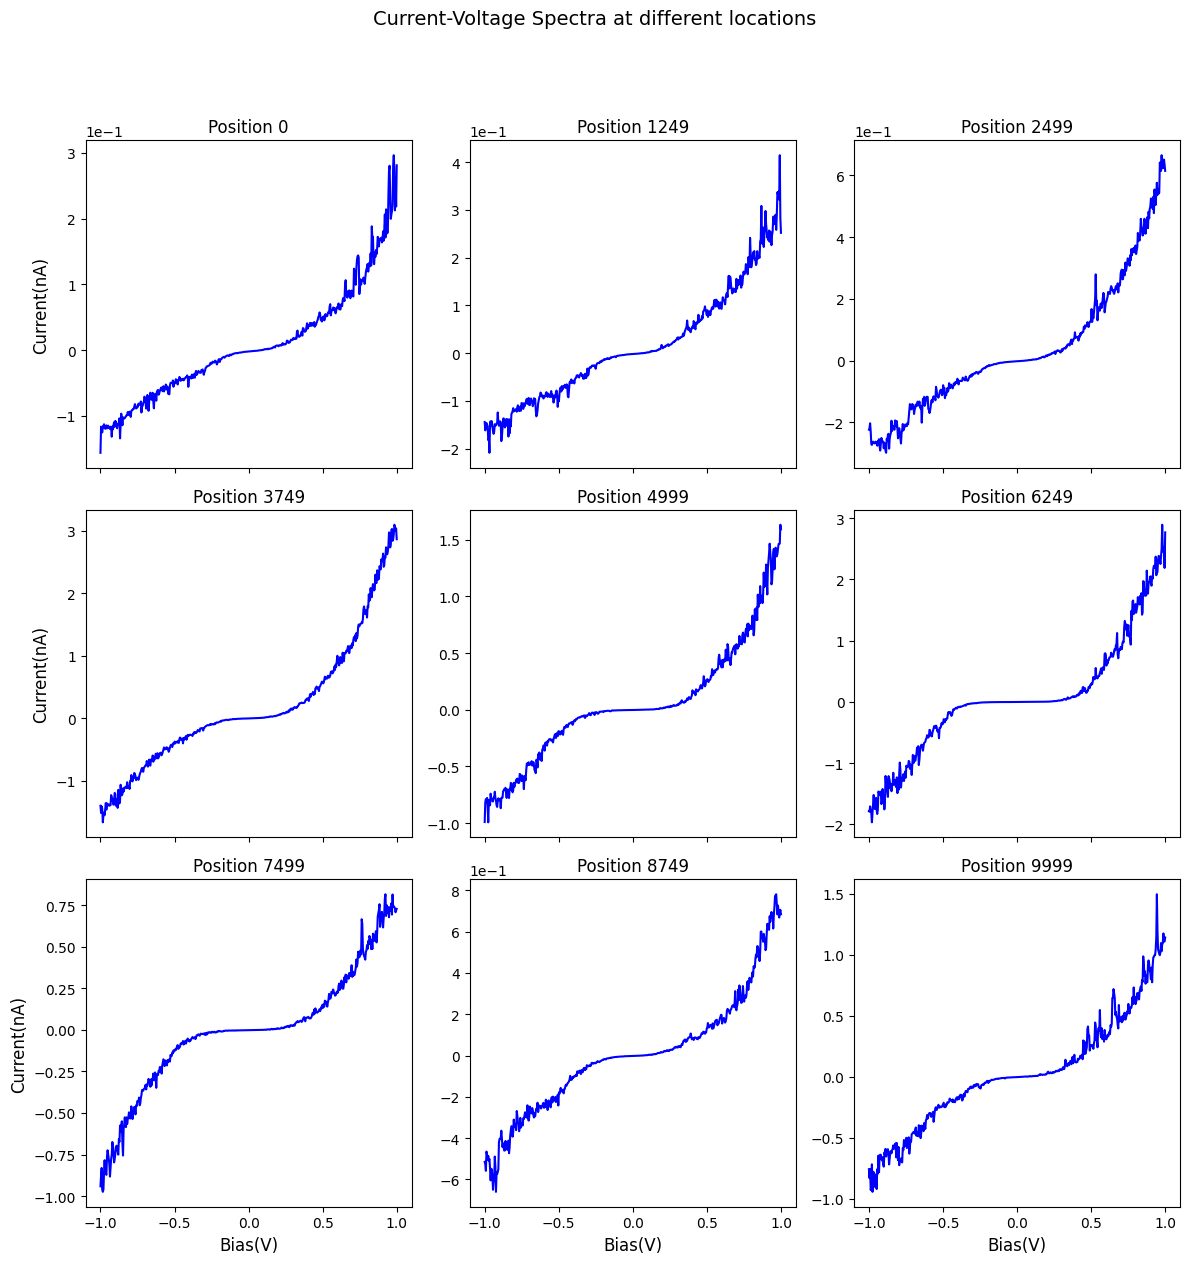

In [11]:
fig, axes = sidpy.plot_utils.plot_curves(bias_vec, raw_data_2d, num_plots=9,
                                        x_label=bias_qty + '(' + bias_units + ')',
                                        y_label=main_qty + '(' + main_units + ')',
                                        title='Current-Voltage Spectra at different locations',
                                        fig_title_yoffset=1.05)

Here is a visualization of spatial maps at different bias values



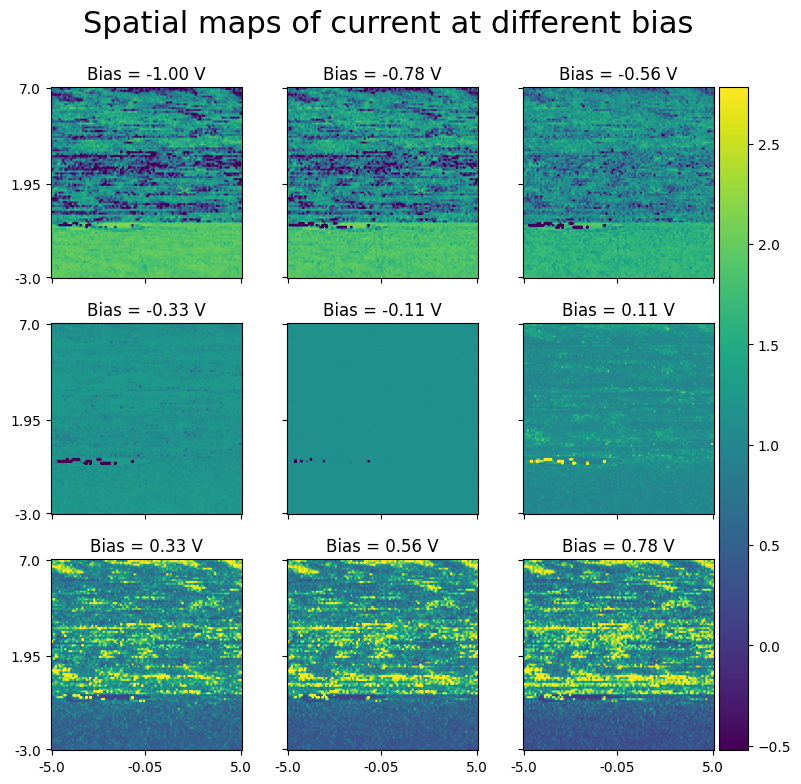

In [12]:
fig, axes = sidpy.plot_utils.plot_map_stack(raw_data_3d, reverse_dims=True, pad_mult=(0.15, 0.15),
                                           title='Spatial maps of current at different bias', stdevs=2,
                                           color_bar_mode='single', num_ticks=3, x_vec=x_vec, y_vec=y_vec,
                                           evenly_spaced=True, fig_mult=(3, 3), title_yoffset=0.95)

for axis, bias_ind in zip(axes, np.linspace(0, len(bias_vec), 9, endpoint=False, dtype=np.uint)):
    axis.set_title('Bias = %3.2f V' % bias_vec[bias_ind])

## 2. Writing information into h5USID files
So far, we have captured all the information from the ``.asc`` files. We are now ready to write the data into USID
formatted HDF5 files! We will be using the ``pyUSID.ArrayTranslator`` class for this stage.

The ``ArrayTranslator`` class can be used in two different ways. We will go over both methods.

### 2.A ArrayTranslator as a quick file writer
Though not intended to be used in this manner, the ``ArrayTranslator`` can be used in scripts to quickly write out
data into a HDF5 file. The benefit over simply saving data using
`numpy.save() <https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html>`_ is that the data will be
written in a way that it will be accessible by the `pyUSID.USIDataset <./plot_usi_dataset.html>`_ class that offers
several handy capabilities. Such usage of the ``ArrayTranslator`` offers minimal benefits over using the
`pyUSID.hdf_utils.write_main_data() <../intermediate/plot_hdf_utils_write.html#write-main-dataset>`_ function,
upon which it is based.

#### 2.A.1 Preparing the name of the new HDF5 file
Below, we will specify the name of the HDF5 file that we want to write the prepared data and metadata. This step
would need to be performed regardless of whether one is writing data out into numpy files, text files, spreadsheets,
or h5USID files (this case).



In [13]:
# First, let us separate the file name from the path to the folder containing the raw data file
folder_path, file_name = os.path.split(data_file_path)
# Next, we will remove the ``.asc`` extension
file_name = file_name[:-4] + '_Script'
# The new file name will share the same base name as the original file but will end with a ``.h5`` extension.
# This HDF5 or H5 file will live in the same folder as the raw data file
h5_path_1 = os.path.join(folder_path, file_name + '.h5')

Indeed, a simple ``replace('.asc', '.h5')`` might have done the same job. However, the above method is recommended

#### 2.A.2 Preparing `Dimension` objects
Before the ``ArrayTranslator`` can be used, we need to formally define the dimensions that define the
three-dimensional measurement in the data file. In this example, we have two `Position` dimensions - ``X`` and ``Y``
and one `Spectroscopic` dimension - ``Bias`` against which data for each spectra were collected.

In pyUSID, we formally define dimensions using simple
`pyUSID.Dimension <../intermediate/plot_write_utils.html#dimension>`_ objects. These ``Dimension`` objects are simply
descriptors of dimensions and take the name of the quantity, physical units, and the values over which the dimension
was varied. Both, the `Position` and `Spectroscopic` dimensions need to be defined using ``Dimension`` objects and the
``Dimension`` objects should be arranged from fastest varying to slowest varying dimensions.

The `Spectroscopic` dimensions are trivial since we only have one dimension - ``Bias``.



In [14]:
spec_dims = usid.Dimension(bias_qty, bias_units, bias_vec)

Given that the spectra were acquired column-by-column and then row-by-row, we would need to arrange the `Position`
dimensions as ``X`` followed by ``Y``.



In [15]:
pos_dims = [usid.Dimension(x_qty, x_units, x_vec),
            usid.Dimension(y_qty, y_units, y_vec)]

#### 2.A.3 Reshape the Main data (if necessary)
Recall that ``Main`` datasets in USID are two dimensional in shape where all position dimensions (``X``, and ``Y`` in
this case) are collapsed along the first axis and the spectroscopic dimensions (``Bias`` in this case) are
collapsed along the second axis. Fortunately, this is exactly how the data was already laid out in the original raw
data file. So, we can use that two-dimensional array as is. We can skip this step.

#### 2.A.4 Writing to a h5USID file
We are now ready to use the ``ArrayTranslator!``
The ArrayTranslator simplifies the creation of h5USID files. It handles the HDF5 file creation,
HDF5 dataset creation and writing, creation of ancillary HDF5 datasets, group creation, writing parameters, linking
ancillary datasets to the main dataset etc. With a single call to the ``translate()`` function of the
``ArrayTranslator``, we complete the translation process:



In [16]:
tran = usid.ArrayTranslator()
_ = tran.translate(h5_path_1, main_data_name,
                   raw_data_2d, main_qty, main_units,
                   pos_dims, spec_dims,
                   parm_dict=parm_dict)

/opt/hostedtoolcache/Python/3.9.21/x64/lib/python3.9/site-packages/sidpy/sid/translator.py:42: FutureWarning: Consider using sidpy.Reader instead of sidpy.Translator if possible and contribute your reader to ScopeReaders
  warn('Consider using sidpy.Reader instead of sidpy.Translator if '
/opt/hostedtoolcache/Python/3.9.21/x64/lib/python3.9/site-packages/pyUSID/io/hdf_utils/simple.py:1072: UserWarning: In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying
  warn('In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying')
/opt/hostedtoolcache/Python/3.9.21/x64/lib/python3.9/site-packages/pyUSID/io/hdf_utils/simple.py:1129: UserWarning: pyUSID.io.hdf_utils.simple.write_ind_val_dsets no longer createsregion references for each dimension. Please use pyUSID.io.reg_ref.write_region_references to manually create region references
  warn('pyUSID.io.hdf_utils.simple.write

### Verifying the newly written H5 file:
Let us perform some simple and quick verification to show that the data has indeed been translated correctly:



Contents of the h5USID file:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Comprehensive information about the Main dataset:
-------------------------------------------------
<HDF5 dataset "Raw_Data": shape (10000, 500), type "<f4">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Current (nA) 
Data dimensions and original shape: 
Position Dimensions: 
	Y - size: 100 
	X - size: 100 
Spectroscopic Dimensions: 
	Bias - size: 500
Data Type:
	float32
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Verification plots:


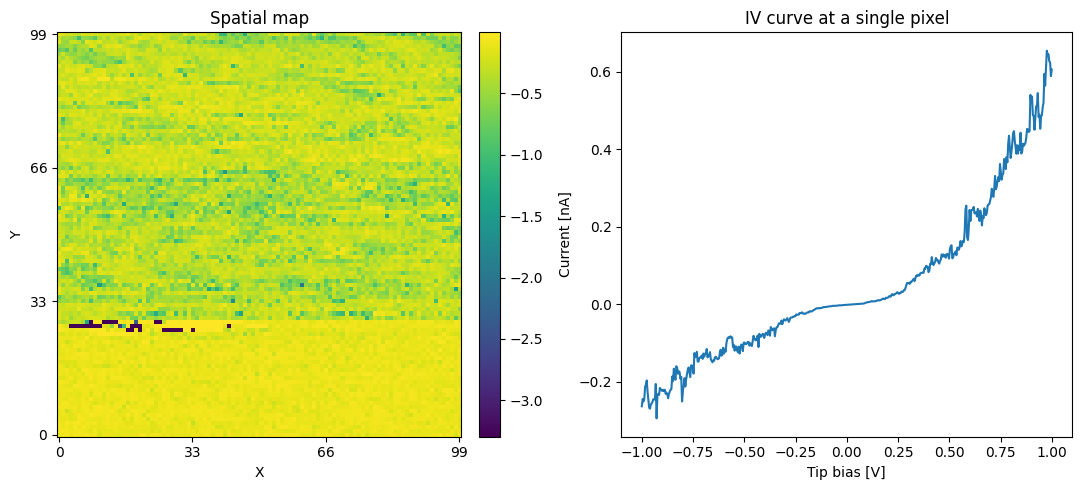

In [17]:
with h5py.File(h5_path_1, mode='r') as h5_file:
    # See if a tree has been created within the hdf5 file:
    print('Contents of the h5USID file:')
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    sidpy.hdf_utils.print_tree(h5_file)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('Comprehensive information about the Main dataset:')
    print('-------------------------------------------------')
    h5_main = usid.hdf_utils.get_all_main(h5_file)[-1]
    print(h5_main)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('Verification plots:')
    fig, axes = plt.subplots(ncols=2, figsize=(11, 5))
    spat_map = np.reshape(h5_main[:, 100], (100, 100))
    sidpy.plot_utils.plot_map(axes[0], spat_map, origin='lower')
    axes[0].set_title('Spatial map')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[1].plot(np.linspace(-1.0, 1.0, h5_main.shape[1]),
                 h5_main[250])
    axes[1].set_title('IV curve at a single pixel')
    axes[1].set_xlabel('Tip bias [V]')
    axes[1].set_ylabel('Current [nA]')

    fig.tight_layout()

### 2.B Extending the ArrayTranslator
What we have done above is essentially, write real measurement data and metadata into a standardized USID HDF5 file.
As is evident above, the process of writing to the HDF5 file is rather simple because of the ``ArrayTranslator``.
However, the above code is part of a script that is susceptible to edits. Minor changes in the naming / formatting of
certain strings, reshaping of the datasets can very quickly break analysis or visualization code later on.
Encapsulating the data reading and writing process into a formal ``Translator`` class also makes it easier for others
to use it and write data into the same consistent format. In fact, upon writing the class, proprietary data files
can be translated using just two lines as we will see below.
Therefore, we recommend extending the ``ArrayTranslator`` class, when possible, instead of using it independently
like a function.

#### 2. B. 1Defining the class
Writing a python class that extends the ``ArrayTranslator`` class is far less intimidating than it sounds. The code
that goes into the class is virtually identical to what has been written above. In fact the code that will be written
below is very similar to real ``Translator`` classes found in our sister package - `pycroscopy`.



In [18]:
class ExampleTranslator(usid.ArrayTranslator):
    """
    The above definition of the class states that our ExampleTranslator inherits all the capabilities and
    behaviors of the ArrayTranslator class and builds on top of it
    """

    def translate(self, input_file_path):
        """
        Extracts the data and metadata out of proprietary formatted files and writes it into a SID formatted HDF5 file

        Parameters
        ----------
        input_file_path : str
            Path to the input data file containing all the information

        Returns
        -------
        h5_path_out_2 : str
            Path to the USID HDF5 output file
        """

        """
        --------------------------------------------------------------------------------------------
        1. Extracting data and metadata out of the proprietary file
        --------------------------------------------------------------------------------------------
        1.2 Read the contents of the file into memory
        """
        with open(input_file_path, 'r') as file_handle:
            string_lines = file_handle.readlines()

        """
        1.3 Extract all experiment and instrument related parameters
        """
        parm_dict = dict()

        for line in string_lines[3:17]:
            line = line.replace('# ', '')
            line = line.replace('\n', '')
            temp = line.split('=')
            test = temp[1].strip()
            try:
                test = float(test)
                if test % 1 == 0:
                    test = int(test)
            except ValueError:
                pass
            parm_dict[temp[0].strip()] = test

        """
        1.4 Extract or generate parameters that define the three dimensions
        """

        num_rows = int(parm_dict['y-pixels'])
        num_cols = int(parm_dict['x-pixels'])
        num_pos = num_rows * num_cols
        spectra_length = int(parm_dict['z-points'])

        # We will assume that data was collected from -3 nm to +7 nm on the Y-axis or along the rows
        y_qty = 'Y'
        y_units = 'nm'
        y_vec = np.linspace(-3, 7, num_rows, endpoint=True)

        # We will assume that data was collected from -5 nm to +5 nm on the X-axis or along the columns
        x_qty = 'X'
        x_units = 'nm'
        x_vec = np.linspace(-5, 5, num_cols, endpoint=True)

        # The bias was sampled from -1 to +1 V in the experiment. Here is how we generate the Bias axis:
        bias_qty = 'Bias'
        bias_units = 'V'
        bias_vec = np.linspace(-1, 1, spectra_length)

        """
        1.5 Extract the data
        """
        num_headers = 403

        raw_data_2d = np.zeros(shape=(num_pos, spectra_length), dtype=np.float32)

        # Iterate over ever measurement position:
        for pos_index in range(num_pos):
            this_line = string_lines[num_headers + pos_index]
            string_spectrum = this_line.split('\t')[:-1]  # omitting the new line
            raw_data_2d[pos_index] = np.array(string_spectrum, dtype=np.float32)

        """
        2.1 Prepare the output file path
        """
        folder_path, file_name = os.path.split(data_file_path)
        h5_path = os.path.join(folder_path, file_name[:-4] + '_Class' + '.h5')

        """
        --------------------------------------------------------------------------------------------
        2.B Writing to h5USID file using pyUSID
        --------------------------------------------------------------------------------------------
        2.B.2 Expressing the Position and Spectroscopic Dimensions using pyUSID.Dimension objects
        """
        pos_dims = [usid.Dimension(x_qty, x_units, x_vec),
                    usid.Dimension(y_qty, y_units, y_vec)]
        spec_dims = usid.Dimension(bias_qty, bias_units, bias_vec)

        """
        2.B.3 Reshape the Main data from its original N-dimensional form to the USID 2D form 
            We skip this step since it is unnecessary in this case
            
        2.B.4 Call the translate() function of the base ArrayTranslator class   
        """
        _ = super(ExampleTranslator, self).translate(h5_path, main_data_name,
                                                     raw_data_2d, main_qty, main_units,
                                                     pos_dims, spec_dims,
                                                     parm_dict=parm_dict)

        return h5_path

### Comments
As you can tell from above, the vast majority of the code in the Class (and the script above it) pertain to the
first phase - the extraction of data and metadata out of the proprietary file format. The parts specific to writing
the data to the h5USID file are no more than 4-5 lines.

As you could tell by now, the code in this class is virtually identical to the code above.
Perhaps the biggest differences between the two codes come in the definition of the class and section ``2.B.4``:

In section ``2.A.4`` above, we had instantiated the ``ArrayTranslator`` and called its ``translate()`` method:

.. code-block:: python

    tran = usid.ArrayTranslator()
    h5_path_out_1 = tran.translate(...)

In the case of the ``ExampleTranslator`` class above, we define the class itself as an extension / child class of the
``ArrayTranslator`` in this line:

.. code-block:: python

    class ExampleTranslator(usid.ArrayTranslator):

This means that our ``ExampleTranslator`` class inherits all the capabilities (including our favorite -
``translate()`` function) and behaviors of the ``ArrayTranslator`` class and builds on top of it. This is why we don't
need to instantiate the ``ArrayTranslator`` in section ``2.B.4``. All we are doing in our ``translate()`` function is
adding the intelligence that is relevant to our specific scientific example and piggybacking on the many capabilities
of the ``ArrayTranslator`` class for the actual file writing. This piggybacking is visible in the last line:

.. code-block:: python

    h5_path_out_1 = super(ExampleTranslator, self).translate(....)

Essentially, we are asking ``ArrayTranslator.translate()`` to take over and do the rest.

#### Using this ExampleTranslator
What we did above is provide a template for what should happen when someone provides an input file. We have not really
tried it out yet. The lines below will illustrate how easy it becomes to perform `translations` from now on:



In [19]:
# instantiate the class first:
my_tran = ExampleTranslator()
# Then call the translate function:
h5_path_2 = my_tran.translate(data_file_path)

/opt/hostedtoolcache/Python/3.9.21/x64/lib/python3.9/site-packages/sidpy/sid/translator.py:42: FutureWarning: Consider using sidpy.Reader instead of sidpy.Translator if possible and contribute your reader to ScopeReaders
  warn('Consider using sidpy.Reader instead of sidpy.Translator if '


/opt/hostedtoolcache/Python/3.9.21/x64/lib/python3.9/site-packages/pyUSID/io/hdf_utils/simple.py:1072: UserWarning: In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying
  warn('In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying')
/opt/hostedtoolcache/Python/3.9.21/x64/lib/python3.9/site-packages/pyUSID/io/hdf_utils/simple.py:1129: UserWarning: pyUSID.io.hdf_utils.simple.write_ind_val_dsets no longer createsregion references for each dimension. Please use pyUSID.io.reg_ref.write_region_references to manually create region references
  warn('pyUSID.io.hdf_utils.simple.write_ind_val_dsets no longer creates'


Once the class is written, translations become a two-line operation!

### Verifying the newly written H5 file:
Let us perform some simple and quick verification to show that the data has indeed been translated correctly:



Contents of the h5USID file:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Comprehensive information about the Main dataset:
-------------------------------------------------
<HDF5 dataset "Raw_Data": shape (10000, 500), type "<f4">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Current (nA) 
Data dimensions and original shape: 
Position Dimensions: 
	Y - size: 100 
	X - size: 100 
Spectroscopic Dimensions: 
	Bias - size: 500
Data Type:
	float32
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Verification plots:


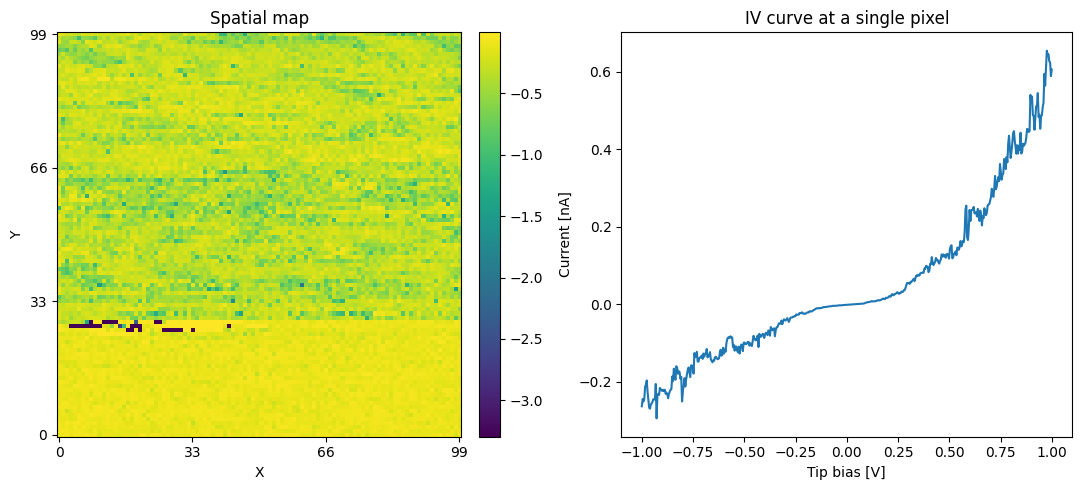

In [20]:
with h5py.File(h5_path_2, mode='r') as h5_file:
    # See if a tree has been created within the hdf5 file:
    print('Contents of the h5USID file:')
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    sidpy.hdf_utils.print_tree(h5_file)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('Comprehensive information about the Main dataset:')
    print('-------------------------------------------------')
    h5_main = usid.hdf_utils.get_all_main(h5_file)[-1]
    print(h5_main)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('Verification plots:')
    fig, axes = plt.subplots(ncols=2, figsize=(11, 5))
    spat_map = np.reshape(h5_main[:, 100], (100, 100))
    sidpy.plot_utils.plot_map(axes[0], spat_map, origin='lower')
    axes[0].set_title('Spatial map')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[1].plot(np.linspace(-1.0, 1.0, h5_main.shape[1]),
                 h5_main[250])
    axes[1].set_title('IV curve at a single pixel')
    axes[1].set_xlabel('Tip bias [V]')
    axes[1].set_ylabel('Current [nA]')

    fig.tight_layout()

### Limits of the ArrayTranslator
The ``ArrayTranslator`` is perfect when one is dealing with a **single** USID `Main` dataset. However, if the
proprietary file contained multiple such 3D hyperspectral images, one would need to use the lower-level functions that
power the ``ArrayTranslator``. pyUSID offers
[several functions](../intermediate/hdf_utils_write.html#write-main-dataset) that make it easy to handle such
more involved translations.

### What about the base Translator class?
The ``pyUSID.Translator`` class is a highly abstract class and does not do much. The ``Translator`` class exists only
to standardize the way in which translators are operated - the instantiation of the class followed by the call to the
``translate()`` method. The ``ArrayTranslator`` is itself
a child class of the ``Translator`` class and is the lowest class capable of doing something by itself while still
being application-agnostic.

### More information
Our sister class - BGLib, has several
[translators](https://github.com/pycroscopy/BGlib/tree/master/BGlib/be/translators) that translate popular
file formats generated by nanoscale imaging instruments. Few translators extend the ``ArrayTranslator`` like
we did above, while most use the low-level functions in ``pyUSID.hdf_utils``.A single, robust Translator class can handle the finer variations / modes in the data. 

We have found python packages online to open a few proprietary file formats and have written translators using these
packages. If you are having trouble reading the data in your files and cannot find any packages online, consider
contacting the manufacturer of the instrument which generated the data in the proprietary format for help.

### Cleaning up
Remove both the original and translated files:



In [21]:
os.remove(h5_path_1)
os.remove(h5_path_2)
os.remove(data_file_path)